In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

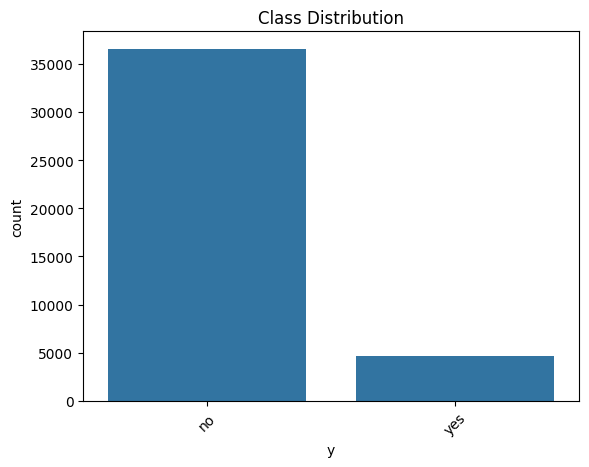

In [2]:
# Load the train dataset 
data = pd.read_csv('bank-additional-full.csv', sep=';')  # Adjust delimiter if needed

# Basic exploration
print(data.info())
print(data.describe())
print(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

## Visualize the class distribution of the target variable y in the train dataset using a count plot.
sns.countplot(x='y', data=data)
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Apply rotation before showing the plot
plt.show()

# Dataset Overview
Total Rows: 41,188
Total Columns: 21
Data Types:
Numerical (10): age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed
Categorical (11): job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, y
No missing values dectected




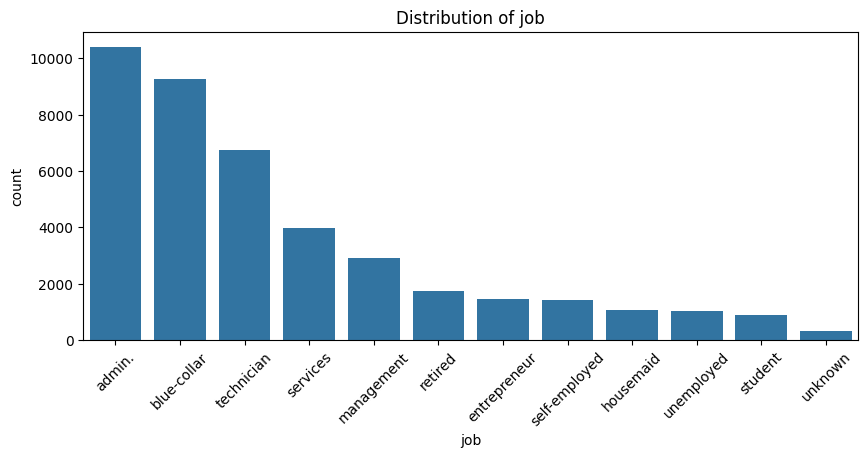

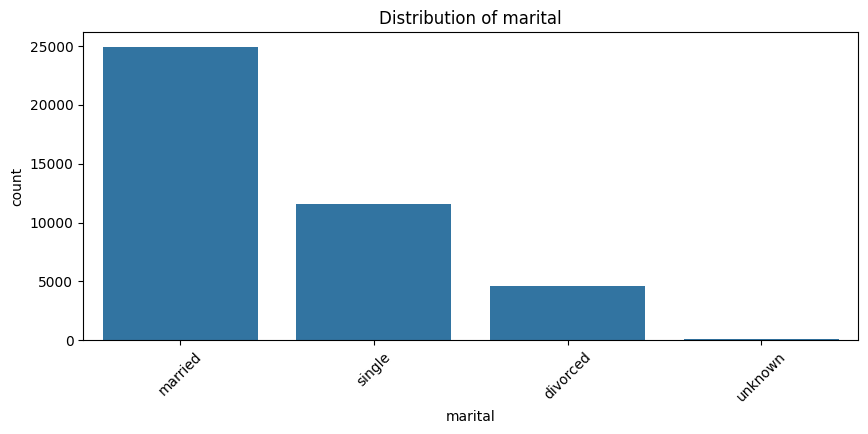

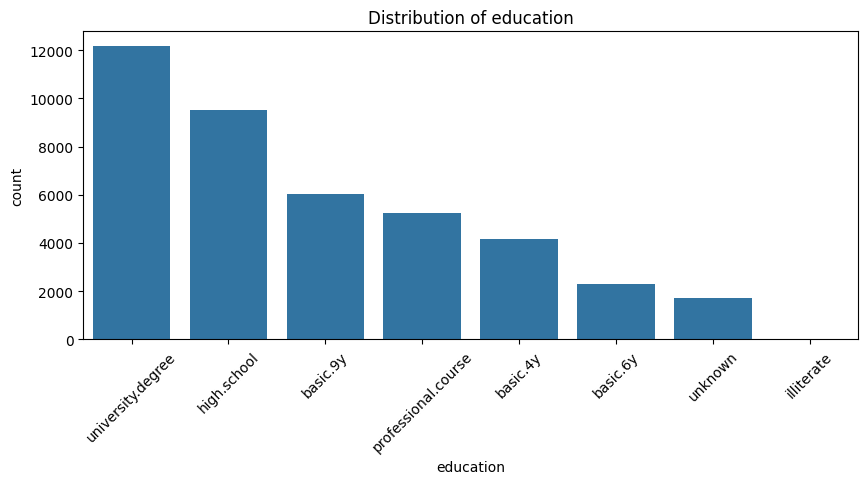

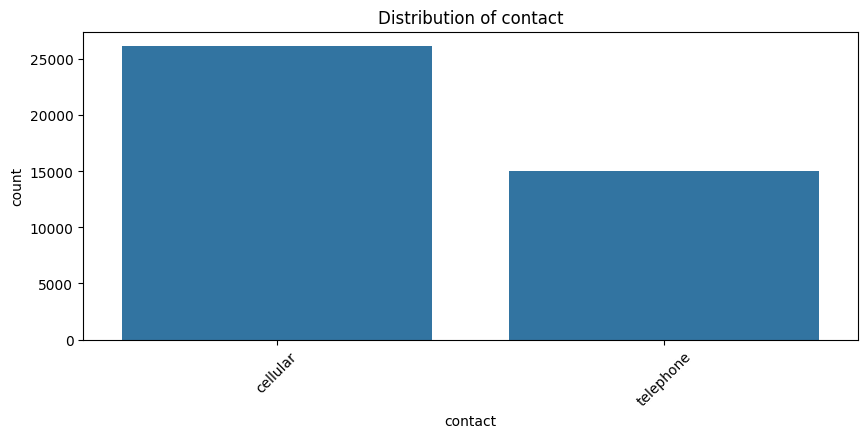

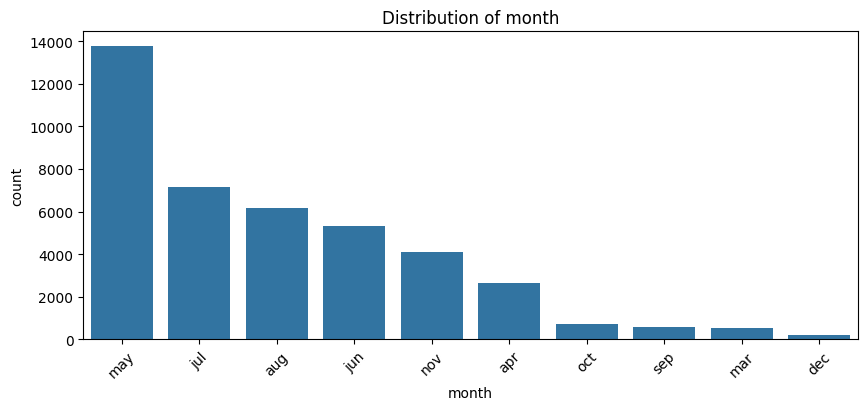

In [3]:
# Categorical Data Exploration:
## Plot distributions for key categorical variables:
categorical_features = ['job', 'marital', 'education', 'contact', 'month']
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=feature, data=data, order=data[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

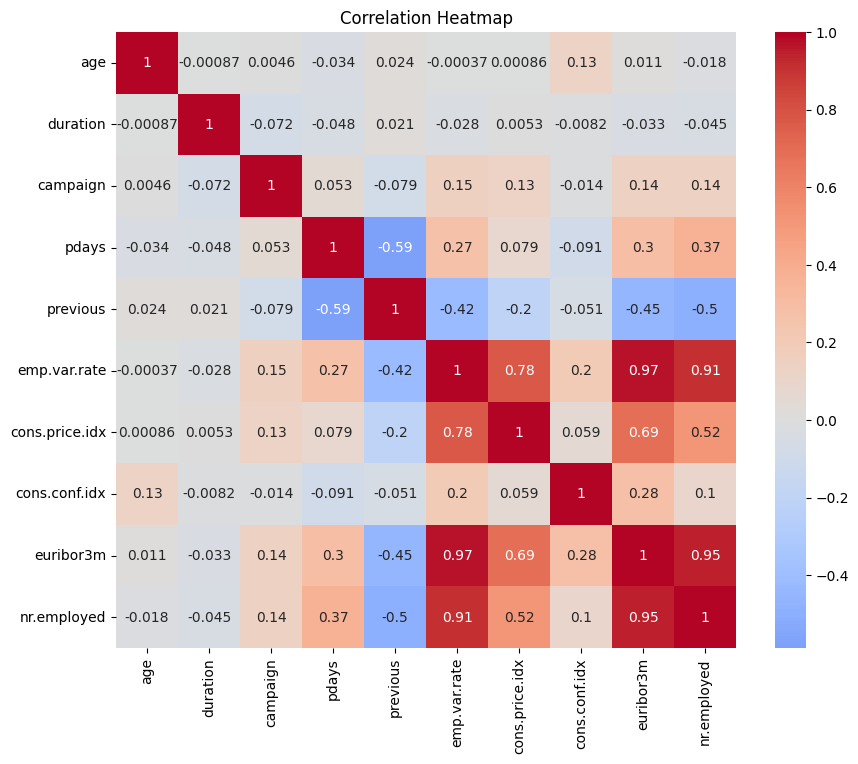

In [4]:
# Select only numeric columns
numeric_columns = data.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

This heatmap visualizes the relationships between numerical variables in the dataset:

Diagonal Elements: All values are 1, as each variable is perfectly correlated with itself.

Highly Correlated Variables: emp.var.rate is strongly correlated with euribor3m and nr.employed (values close to 1), all related to economic indicators. euribor3m and nr.employed are also strongly correlated (0.94).

Negative Correlations: pdays is negatively correlated with previous (-0.59). Weak negative correlations exist for emp.var.rate and previous.

Weak or No Correlation: Variables like age, campaign, and others show negligible linear relationships.

Feature Engineering Insights: Strongly correlated variables (e.g., emp.var.rate, euribor3m, nr.employed) may cause multicollinearity; consider removing one.

Variables like pdays and previous offer distinct relationships valuable for modeling.


In [5]:
# The duration column provides post-outcome information, so we must exclude it immediately.
# Drop 'duration' to avoid data leakage
data = data.drop(columns=['duration'])


In [6]:

# Preprocessing pipeline
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = le.fit_transform(data[col])

# Recalculate correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)

                     age       job   marital  education   default   housing  \
age             1.000000  0.001250 -0.389753  -0.117892  0.164965 -0.001603   
job             0.001250  1.000000  0.027897   0.134121 -0.028277  0.006962   
marital        -0.389753  0.027897  1.000000   0.109220 -0.079450  0.010467   
education      -0.117892  0.134121  0.109220   1.000000 -0.186859  0.016825   
default         0.164965 -0.028277 -0.079450  -0.186859  1.000000 -0.015815   
housing        -0.001603  0.006962  0.010467   0.016825 -0.015815  1.000000   
loan           -0.007368 -0.010209  0.005788   0.006384 -0.003782  0.044296   
contact         0.007021 -0.025132 -0.054501  -0.105726  0.135238 -0.082186   
month          -0.024877 -0.033213 -0.007629  -0.082684 -0.015830 -0.018141   
day_of_week    -0.017572 -0.000844  0.002202  -0.017986 -0.008701  0.003339   
campaign        0.004594 -0.006923 -0.007240   0.000371  0.032825 -0.011010   
pdays          -0.034369 -0.028468 -0.037942  -0.046

In [7]:
# Calculate variance for all numeric features
low_variance_threshold = 0.01  # Define a threshold for low variance
numeric_features = data.select_dtypes(include=['int64', 'float64'])
low_variance_features = numeric_features.var()[numeric_features.var() < low_variance_threshold].index
print("Low variance features:", low_variance_features)

# Drop low-variance features
data = data.drop(columns=low_variance_features)

Low variance features: Index([], dtype='object')


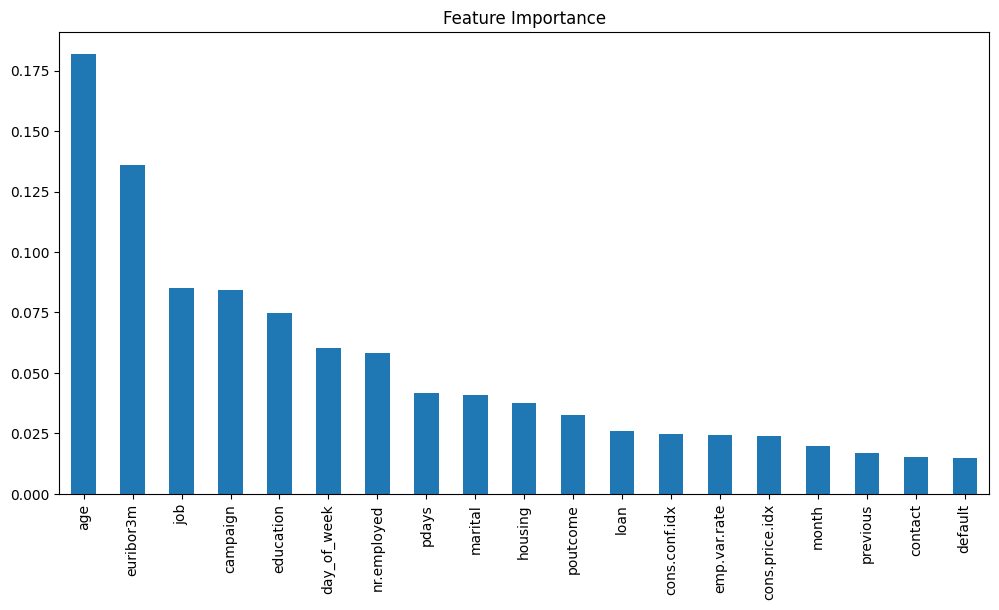

Selected features: Index(['age', 'euribor3m', 'job', 'campaign', 'education', 'day_of_week',
       'nr.employed', 'pdays', 'marital', 'housing', 'poutcome', 'loan',
       'cons.conf.idx', 'emp.var.rate', 'cons.price.idx', 'month', 'previous',
       'contact', 'default'],
      dtype='object')


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# Encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

# Split data into features and target
X = data_encoded.drop(columns=['y'])
y = data_encoded['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest to determine feature importance
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Feature importance
importances = pd.Series(model.feature_importances_, index=X_train.columns)
important_features = importances.sort_values(ascending=False)

# Visualize feature importance
import matplotlib.pyplot as plt
important_features.plot(kind='bar', figsize=(12, 6), title="Feature Importance")
plt.show()

# Select features based on importance
threshold = 0.01  # Retain features with importance > threshold
selected_features = important_features[important_features > threshold].index
print("Selected features:", selected_features)

# Keep only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [10]:
from sklearn.metrics import accuracy_score, classification_report

# Train and evaluate with selected features
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8917212915756252
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7303
           1       0.54      0.30      0.38       935

    accuracy                           0.89      8238
   macro avg       0.73      0.63      0.66      8238
weighted avg       0.87      0.89      0.88      8238



In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y.value_counts())
print("Resampled class distribution:\n", y_train_smote.value_counts())

c:\Users\lenovo\Desktop\Assessment\PDM-TERM-DEPOSIT\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\lenovo\Desktop\Assessment\PDM-TERM-DEPOSIT\venv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original class distribution:
 y
0    36548
1     4640
Name: count, dtype: int64
Resampled class distribution:
 y
0    29245
1    29245
Name: count, dtype: int64


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize Logistic Regression with class weights
model = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83      7303
           1       0.25      0.69      0.37       935

    accuracy                           0.73      8238
   macro avg       0.60      0.71      0.60      8238
weighted avg       0.87      0.73      0.78      8238



c:\Users\lenovo\Desktop\Assessment\PDM-TERM-DEPOSIT\venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

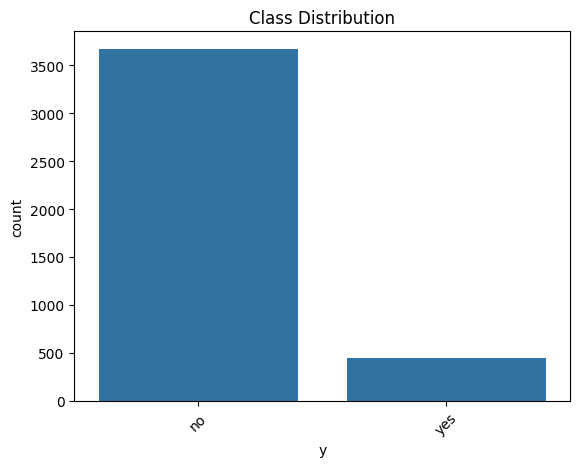

In [5]:
# Load the test dataset
data = pd.read_csv('bank-additional.csv', sep=';')  # Adjust delimiter if needed

# Basic exploration
print(data.info())
print(data.describe())
print(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

## Visualize the class distribution of the target variable y in the train dataset using a count plot.
sns.countplot(x='y', data=data)
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Apply rotation before showing the plot
plt.show()


3. Data Preprocessing and Feature Engineering

In [ ]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Encode categorical variables
data = pd.get_dummies(data, drop_first=True)

# Separate features and target
X = data.drop('y_yes', axis=1)  # 'y_yes' is the encoded target variable
y = data['y_yes']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
4. Build and Train a Predictive Model